In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

In [2]:
data=pd.read_csv('data/headstart.csv')
len_before=len(data.index)
data=data.dropna(how='any',subset=['povrate60','mort_age59_related_postHS','census1960_pop'])
len_after=len(data.index)
print('Dropped',len_before-len_after,'lines that contain NaN.')
threshold=59.1984

Dropped 26 lines that contain NaN.


In [3]:
def ker_tri(x):
    return 2*(1-x)
def ker_rect(x):
    return 1 # Note that the constant here will not affect the result

In [4]:
def get_interval(X,Y,a,b):
    return X[np.logical_and(a<X,X<b)],Y[np.logical_and(a<X,X<b)]

In [93]:
"""
X=data['povrate60'].values
Y=data['mort_age59_related_postHS'].values
restriction=Y<=40
X=X[restriction]
Y=Y[restriction]
"""
n=300
X=np.random.rand(n)*10-5+threshold
def actual_f(x):
    return 0.3*((x-59)**2)+2
Y=np.vectorize(actual_f)(X)+np.random.rand(n)-0.5

In [86]:
# Left regression only
def bias1(X,Y,t,k,b):
    X0=X[np.logical_and(t-b<X,X<t)]
    X1=X0-t                             #take threshold to x=0
    Y1=Y[np.logical_and(t-b<X,X<t)]
    get_weight=np.vectorize(lambda x:k((np.abs(x))/b))
    WL=get_weight(X1)
    XW=X1*WL                            #weighted X1
    XXW=X1**2*WL                        #weighted X1^2
    YW=Y1*WL                            #weighted Y1
    #averages
    Wsum=np.sum(WL)
    XXavg=np.sum(XXW)/Wsum
    Xavg=np.sum(XW)/Wsum
    Yavg=np.sum(YW)/Wsum
    regr = linear_model.LinearRegression()
    regr.fit(X1.reshape(-1,1), Y1, sample_weight=WL)
    a=regr.coef_                        #find the slope of regression
    f1=WL*((a*(X1-Xavg)-(Y1-Yavg))**2)
    f2=WL*(X1-XXavg)**2
    n=np.size(X1)
    F=XXavg*np.sum(f1)/((n-2)*np.sum(f2))
    return F

In [87]:
# Left regression only
def bias2(X,Y,t,k,b,regr2):
    X,Y=get_interval(X,Y,t-b,t)
    get_weight=np.vectorize(lambda x:k((np.abs(x-t))/b))
    WL=get_weight(X)
    #averages
    X1=X.reshape(-1,1)
    X2=np.hstack([X1,X1**2])
    regr1 = linear_model.LinearRegression()
    regr1.fit(X1,regr2.predict(X2),sample_weight=WL)
    err=(regr1.predict([[t]])-regr2.predict([[t,t**2]]))[0]
    return err**2

In [88]:
# t is the threshold, k is a kernel function [0,1]->R, and b is the bandwidth
# Currently supports only 1D array
# Regression from left of t
def regr_sided(X,Y,t,k,b):
    # Dispose points outside bandwidth
    YL=Y[np.logical_and(t-b<X,X<t)]
    XL=X[np.logical_and(t-b<X,X<t)]
    
    # Calculate weights
    get_weight=np.vectorize(lambda x:k((np.abs((x-t)))/b))
    WL=get_weight(XL)

    # Reshape for lib use
    # Every data has a single feature
    XL=XL.reshape(-1,1)
    YL=YL.reshape(-1,1)
    
    # Create linear regression object
    regrL = linear_model.LinearRegression()
    
    # Train the model using the training sets
    regrL.fit(XL, YL, sample_weight=WL)
    
    return regrL

black: data points, red: predicted by regression, green: hidden true values


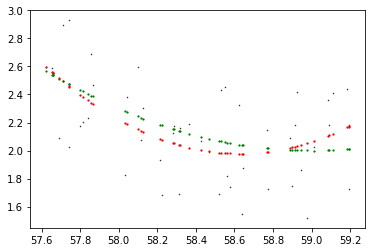

blue: bias1, green: bias2, black: all bias, red: true bias


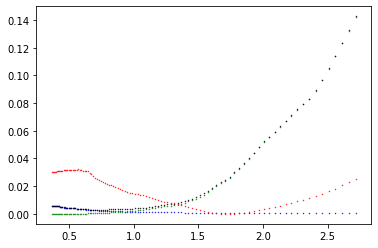

In [94]:
def get_regr2(X,Y,t,k,b):
    X,Y=get_interval(X,Y,t-b,t)
    get_weight=np.vectorize(lambda x:k((np.abs(x-t))/b))
    WL=get_weight(X)
    X1=X.reshape(-1,1)
    X2=np.hstack([X1,X1**2])
    regr2 = linear_model.LinearRegression()
    regr2.fit(X2, Y, sample_weight=WL)
    print('black: data points, red: predicted by regression, green: hidden true values')
    plt.scatter(X,Y, s=0.2, color='black')
    plt.scatter(X, regr2.predict(X2),s=1.5, color='red')
    plt.scatter(X, np.vectorize(actual_f)(X),s=1.5, color='green')
    plt.show()
    return regr2

regr2=get_regr2(X,Y,threshold,ker_rect,1.6)

def test_bandwidth_joined(X,Y,t,k):
    for i in np.exp(np.linspace(-1,1,100)):
        err1=bias1(X,Y,t,k,i)
        err2=bias2(X,Y,t,k,i,regr2)
        plt.scatter(i, err1, s=0.2, color='blue')
        plt.scatter(i, err2, s=0.2, color='green')
        plt.scatter(i, err1+err2, s=0.2, color='black')
        final_regr=regr_sided(X,Y,t,k,i)
        true_err=(final_regr.predict([[t]])[0][0]-actual_f(t))**2
        plt.scatter(i, true_err, s=0.2, color='red')
    print('blue: bias1, green: bias2, black: all bias, red: true bias')
    plt.show()
    
test_bandwidth_joined(X,Y,threshold,ker_tri)